# Nanostructures out of equilibrium with Python

### © Branislav K. Nikolić and Marko D. Petrović, University of Delaware
[PHYS824: Nanophysics & Nanotechnology](https://wiki.physics.udel.edu/phys824) 

## What is covered in this notebook

Using [NEGF-based implementation](https://wiki.physics.udel.edu/wiki_phys824/images/2/27/Negf_formulas_in_pictures.pdf) of the Landauer conductance formula, we compute:

- Zero-temperature conductance of one-dimensional (1D) tight-binding nanowire, which is clean or it contains impurities, attached to two ideal (with no impurities or other interactions) semi-infinite 1D tight-binding leads
- Aharonov-Bohm (AB) ring, modeled as 1D tight-binding circle, attached to two semi-infinite 1D tight-binding ideal leads:
  - Energy spectrum of an isolated AB ring
  - Conductance vs. magnetic flux of AB ring
- Tunneling magnetoresistance (TMR) of magnetic tunnel junctions (MTJs): 
  - 1D tight-binding model in real-space representation
  - 3D tight-binding model in mixed real-space and k-space representation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1. Zero-temperature conductance of 1D tight-binding nanowires

## 1.1 Clean nanowire
We consider 1D nanowire described by tight-binding Hamiltonian

$$\hat{H} = \sum_{i=1}^{N} \epsilon_{i}|i\rangle\langle i| 
            -t\sum_{i=1}^{N} \left(|i\rangle\langle i+1| + |i+1\rangle\langle i|
            \right)$$ 

composed of $N$ atoms with one localized orbital $|i\rangle$ per each atom. The hopping within the nanowire $t$ sets the unit of energy in which we express the hopping in the leads $t_\mathrm{L}$ or between the leads and the nanowire $t_\mathrm{C}$.

First, we define a function for the [self-energy of 1D semi-infinite leads](https://wiki.physics.udel.edu/wiki_phys824/images/6/62/Self_energy_lead.pdf)

In [6]:
import numpy as np

def selfenergy(energy, t_couple=1.0, t_lead=1.0):
    """Compute the selfenergy of a semi-infinite lead
    
    Parameters
    ----------
    tc : float
        Coupling between the lead and the main scattering region.
    tl : float
        Coupling within the lead.
    
    Returns
    -------
    selfenergy : float
    """
    
    rad = 4*t_lead**2 - energy**2
    coef = t_couple**2 / (2*t_lead**2)
    
    if (rad > 0):
        se = coef * (energy - 1j*np.sqrt(rad)) 
    else:
        se = coef * (energy - np.sign(energy)*np.sqrt(-rad))
    
    return se

In [7]:
selfenergy(2.5)

0.5

In [8]:
import matplotlib.pyplot as plt

def solve_wire(nx=5, onsite=0, t=1.0, tc=1.0, tl=1.0,
               ximp1=0, ximp2=2, v_imp1=1.0, v_imp2=2.0,
               ldos_site=2):
    
    # Construct the hamiltonian
    ham = np.diag(onsite*np.ones(nx, dtype=complex))
    ham += -t*np.diag(np.ones(nx-1), 1)
    ham += -t*np.diag(np.ones(nx-1), -1)

    # Add impurity potentias
    ham[ximp1, ximp1] += v_imp1
    ham[ximp2, ximp2] += v_imp2

    pot_left = ham[0, 0]
    pot_right = ham[-1, -1]

    energies = np.linspace(-3, 3, 101)
    transmission = []
    ldos = []
    dos = []
    reflection = []

    for en in energies:
        se = selfenergy(en, t_couple=tc, t_lead=tl) 
        ham[0, 0] = pot_left + se
        ham[-1, -1] = pot_right + se
        green_r = np.linalg.inv(en*np.eye(nx) - ham)
        green_a = np.conj(green_r.T)
        gamma = 1j*(se - np.conj(se))   # Level broadening matrix
    
        # Compute transmission
        trans = gamma * green_r[-1, 0] * gamma * green_a[0, -1]
        transmission.append(trans.real)
    
        # Compute LDOS
        ld = -1/np.pi * (green_r[ldos_site, ldos_site]).imag
        ldos.append(ld)

        # Compute DOS
        dd = -1/np.pi * np.trace(green_r)
        dos.append(dd.imag)
    
        # Compute reflection
        sq = np.sqrt(abs(gamma))
        refl = (-1 + 1j*sq*green_r[0, 0]*sq)*(-1-1j*sq*np.conj(green_r[0, 0])*sq)
        reflection.append(refl)
    
    # Plot results
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(energies, transmission);
    axs[0, 0].set_ylabel('Transmission')
    axs[0, 1].plot(energies, reflection);
    axs[0, 1].set_ylabel('Reflection')
    axs[1, 0].plot(energies, ldos);
    axs[1, 0].set_ylabel('LDOS')
    axs[1, 1].plot(energies, dos);
    axs[1, 1].set_ylabel('DOS')

    for ax in [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]:
        ax.set_xlim(-3, 3)
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_xlabel('Fermi Energy (t)')
    fig.tight_layout(h_pad=1.0, w_pad=2.0)
    fig.set_dpi(300)

/opt/anaconda/2019.07/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


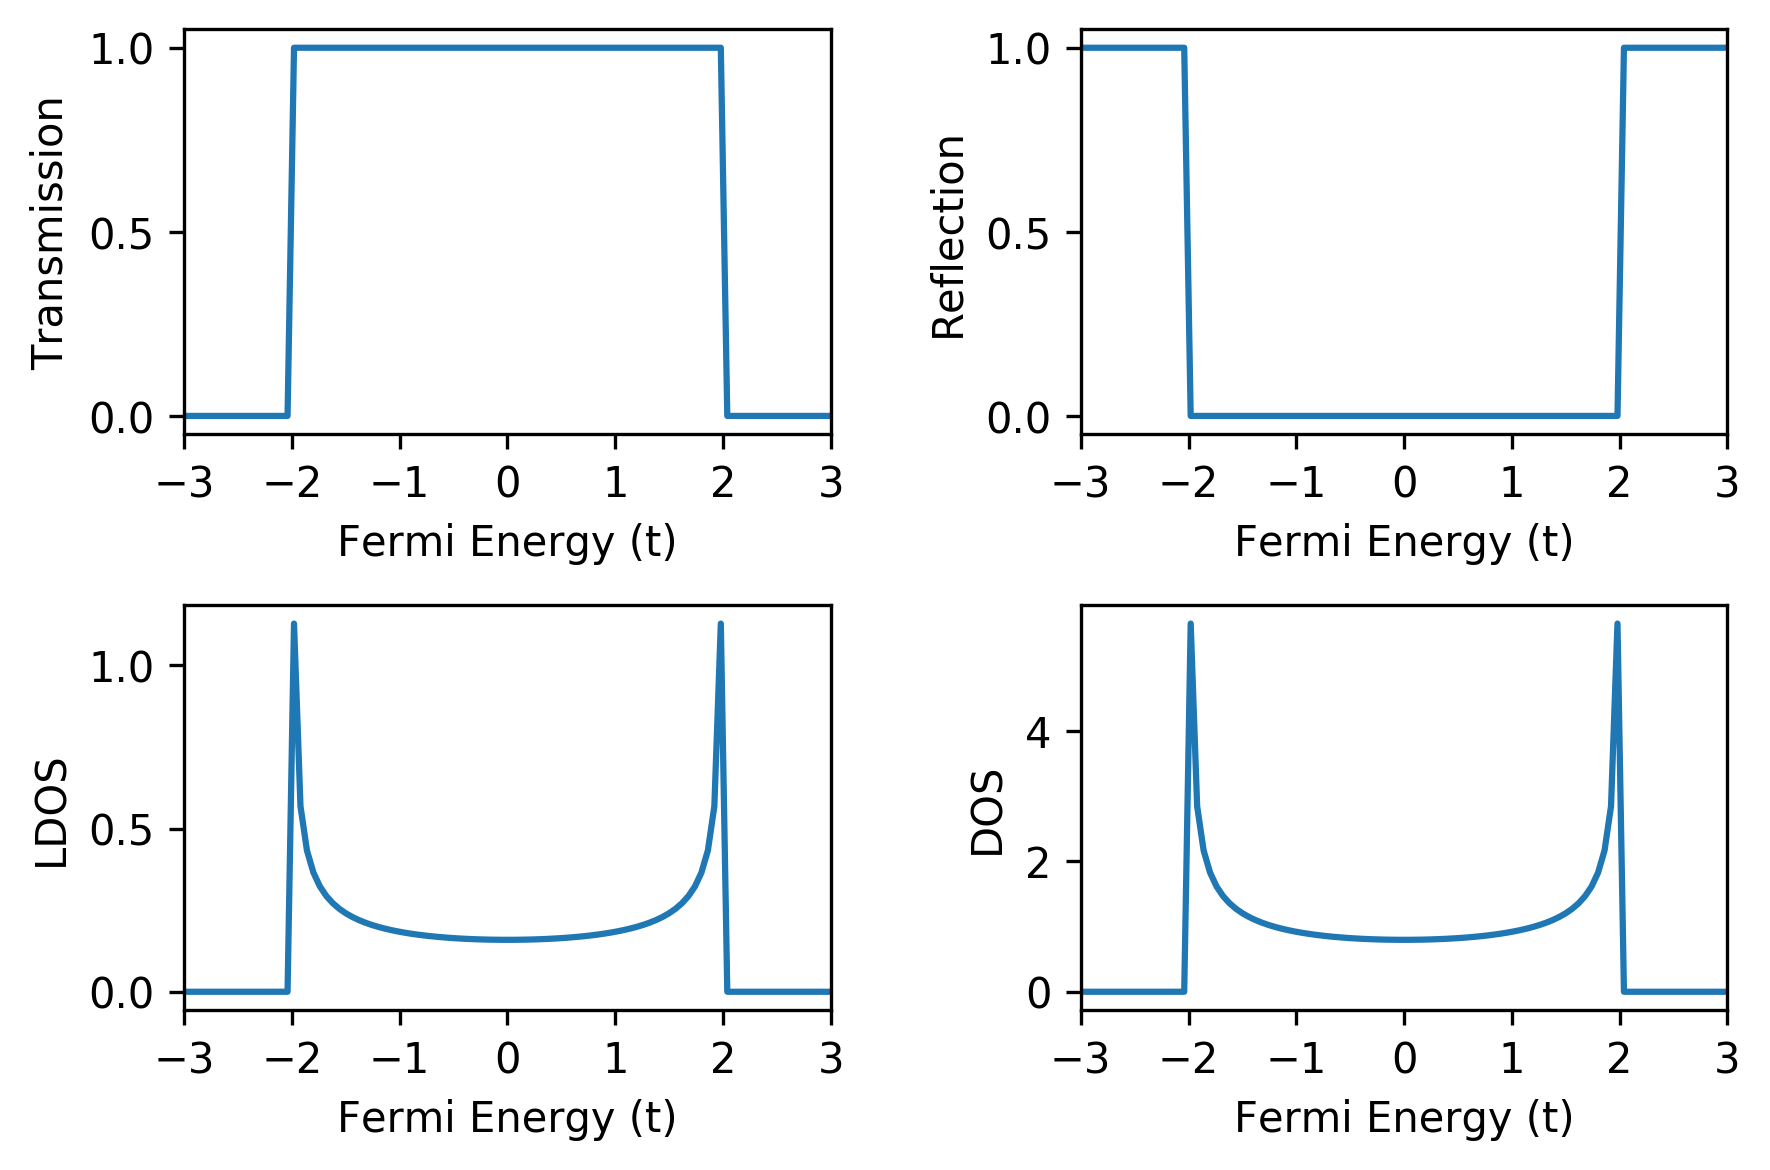

In [9]:
solve_wire(nx=5, t=1.0, tc=1.0, tl=1.0, ximp1=0,
           ximp2=2, v_imp1=0.0, v_imp2=0.0, ldos_site=2)

## 1.2 Resonant tunneling in disordered nanowire with two impurities

Repeat by introducing two impurities at two different sites along the nanowire: 

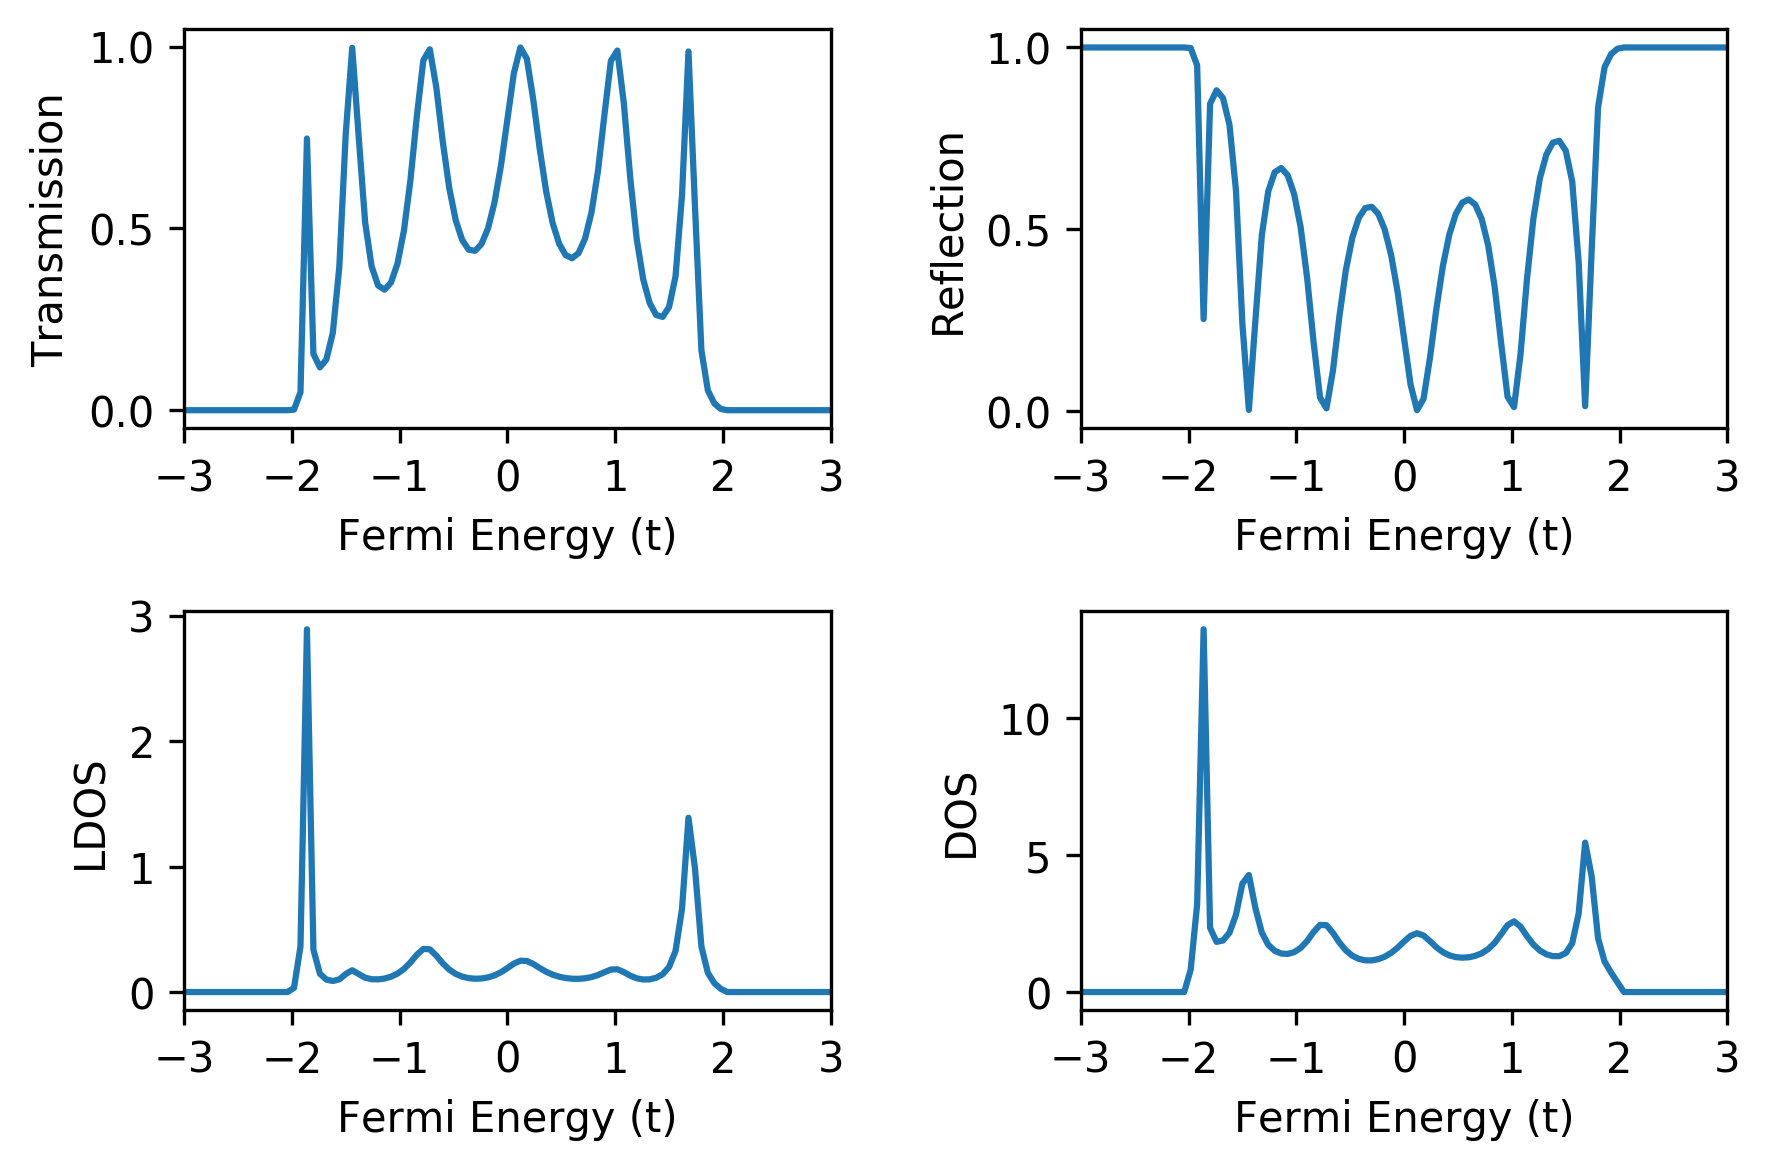

In [10]:
solve_wire(nx=10, t=1.0, tc=1.0, tl=1.0, ximp1=2,
           ximp2=9, v_imp1=1.0, v_imp2=1.0, ldos_site=6)

# 2 Aharonov-Bohm ring made of 1D nanowires


<img src='https://wiki.physics.udel.edu/wiki_phys824/images/d/dd/1D_ring_system.png' width='600px'>

The ring system consists of two arms with a Hamiltonian given by

$$\hat{H} = \sum_{i=1}^{N} \epsilon_{i}|i\rangle\langle i| 
            -t\sum_{i=1}^{N} \left(
            e^{i\phi'/N}|i+1\rangle\langle i| + 
            e^{-i\phi'/N}|i\rangle\langle i+1|
            \right)$$ 
where $\phi' = 2\pi\, \Phi/\Phi_0$. 

In [11]:
def ring_transmission(energy, n=10, phi=0, onsite=0, t=1):
    
    ham = np.diag(onsite*np.ones(n, dtype=complex))
    phase = np.exp(1j*2*np.pi*phi/n)
    
    ham += (np.diag((-t)*np.ones(n-1), 1)*phase)
    ham += (np.diag((-t)*np.ones(n-1), -1)*np.conj(phase))
    
    # Impose periodic boundry condition (make a ring)
    ham[0, -1] = -t*np.conj(phase)
    ham[-1, 0] = -t*phase
    se = selfenergy(energy) 
    n_half = int(n/2)
    ham[0, 0] += se
    ham[n_half, n_half] += se
    green_r = np.linalg.inv(energy*np.eye(n) - ham)
    green_a = np.conj(green_r.T)
    gamma = 1j*(se - np.conj(se))   # Level broadening matrix
    
    # Compute transmission
    trans = gamma * green_r[n_half, 0] * gamma * green_a[0, n_half]
    return trans.real 

## 2.1 Zero-temperature conductance as a function of magnetic flux

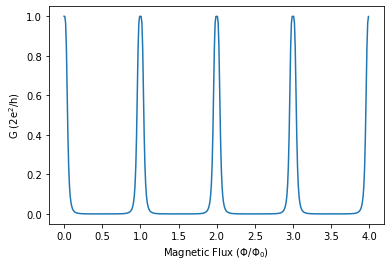

In [12]:
phis = np.arange(0, 4, 0.01)
trans = []
for phi in phis:
    print('%.2f \r' % phi, end='')
    trans.append(ring_transmission(energy=0.01, n=8, phi=phi))   # Try two cases: Fermi energy = 0.01 or 1.0
plt.plot(phis, trans);
plt.xlabel(r'Magnetic Flux $\left(\Phi / \Phi_0\right)$');
plt.ylabel(r'${\rm G}\ \left(\rm 2e^2/h\right)$');

## 2.2 Zero-temperature conductance as a function of energy

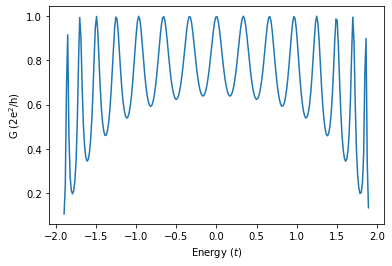

In [13]:
energies = np.arange(-1.9, 1.9, 0.015)
trans = []
for energy in energies:
    print('%.2f \r' % energy, end='')
    trans.append(ring_transmission(energy, n=40, phi=0))
plt.plot(energies, trans);
plt.xlabel(r'${\rm Energy}\ (t)$');
plt.ylabel(r'${\rm G}\ \left(\rm 2e^2/h\right)$');

## 2.3 Energy spectrum of an isolated ring

In [14]:
def ring_spectrum(n=10, phi=0, onsite=0, t=1):
    
    ham = np.diag(onsite*np.ones(n, dtype=complex))
    phase = np.exp(1j*2*np.pi*phi/n)
    
    ham += (np.diag((-t)*np.ones(n-1), 1)*phase)
    ham += (np.diag((-t)*np.ones(n-1), -1)*np.conj(phase))
    
    # Impose periodic boundry condition (make a ring)
    ham[0, -1] = -t*np.conj(phase)
    ham[-1, 0] = -t*phase
    evals, evects = np.linalg.eig(ham)
    return evals

(5000, 10)


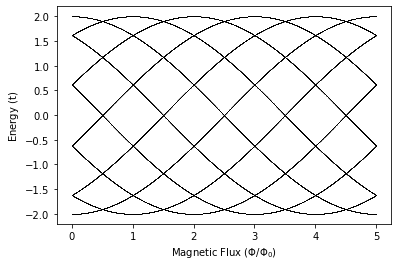

In [15]:
phis = np.arange(0, 5, 0.001)
evals = []
for phi in phis:
    print('%.2f \r' % energy, end='')
    evals.append(ring_spectrum(n=10, phi=phi))
evals = np.array(evals)
print(evals.shape)
for line in evals.T:
    plt.plot(phis, line, c='black', lw=0, marker='o', mew=0, ms=0.5);
plt.ylabel(r'${\rm Energy}\ (\rm t)$');
plt.xlabel(r'Magnetic Flux $\left({\rm \Phi/\Phi_0}\right)$');

# 3 TMR of MTJs

## 3.1 1D tight-binding real-space model of MTJ 

We model MTJ as semi-infinite-FM-lead/I/semi-infinite-FM-lead, where FM is ferromagnetic metal and I is a tunnel barrier. The semi-infinite FM leads are described by 1D tight-binding Hamiltonian

$$\hat{H}_\mathrm{FM} = - \frac{J_\mathrm{exc}}{2} \mathbf{m} \cdot \hat{\boldsymbol{\sigma}} \sum_{i=1}^{\infty}  |i\rangle\langle i| 
            -t \hat{I}_2 \sum_{i=1}^{\infty} \left(|i\rangle\langle i+1| + |i+1\rangle\langle i|
            \right)$$ 

with $\mathbf{m}$ being the unit vector along the magnetization of FM; $\hat{\boldsymbol{\sigma}}=(\hat{\sigma}_x,\hat{\sigma}_y,\hat{\sigma}_z)$ is the vector of the Pauli matrices; $J_\mathrm{exc}$ quantifies exchange interaction between conduction electrons and localized magnetic moments of FM; and $\hat{I}_2$ is the unit $2 \times 2$ matrix. The tunnel barrier is described by 1D tight-binding Hamiltonian

$$\hat{H} = \sum_{i=1}^{N} \epsilon|i\rangle\langle i| 
            -t\sum_{i=1}^{N} \left(|i\rangle\langle i+1| + |i+1\rangle\langle i|
            \right)$$

composed of finite number of sites $N$ and its "barrier function" is enabled by using the on-site potential $\epsilon>0$ which is the same on all sites.

Tunneling magentoresistance (TMR) is defined by (using the so-called optimistic definition):

$$ \mathrm{TMR} = \frac{G_\mathrm{P} - G_\mathrm{AP}}{G_\mathrm{AP}} $$

where $G_\mathrm{P}$ is the conductance in the parallel configuration of two magnetizations $\mathbf{m}$, and  $G_\mathrm{AP}$ is the conductance in the antiparallel configuration. Both conductance can be obtained using the Landauer formula (at zero temperature):

$$G_\mathrm{P,AP} = \frac{e^2}{h} T_\mathrm{P,AP}(E)$$

where $T_\mathrm{P}(E)$ and $T_\mathrm{AP}(E)$ are the corresponding transmission functions.

Define function for spin-dependent self-energy of a semi-infinite FM lead:

In [16]:
def selfenergy_spin(energy, jexc=0, t_couple=1.0, t_lead=1.0):
    se = np.zeros((2, 2), dtype=complex)
    energy_up = energy - (-jexc/2.)
    se_up = selfenergy(energy_up, t_couple, t_lead)
    
    energy_down = energy - jexc/2.
    se_down = selfenergy(energy_down, t_couple, t_lead)
    se[0, 0] = se_up
    se[1, 1] = se_down
    return se

Define function for computing the transmission functions $T_\mathrm{P}(E)$ and  $T_\mathrm{AP}(E)$:

In [17]:
def mtj_trans(n=5, t=1, ub=0, fermi_energy=0.5, jexc=0.9, parallel=True):
    """Compute transmission through MTJ
    
    Parameters
    ----------
    n : int
        Number of sites
    t : float
        Hopping constant 
    ub : float
        Tunnel barrier potential
    fermi_energy : float
        Fermi energy measured from the bottom of the band
    jexc : float
        Exchange splitting in relative units of the band energy
        jexc*(ef - eb)
    """
    
    e_bottom = -2*t   # Bottom of the band
    delta = jexc*(fermi_energy - e_bottom)
    onsite = ub - delta/2.
    ham = np.diag(onsite*np.ones(n, dtype=complex))
    ham += np.diag(-t*np.ones(n-1), 1)
    ham += np.diag(-t*np.ones(n-1), -1)
    ham = np.kron(ham, np.eye(2))
    
    se_left = selfenergy_spin(fermi_energy, jexc=delta)
    
    if parallel:
        se_right = selfenergy_spin(fermi_energy, jexc=delta)
    else:
        se_right = selfenergy_spin(fermi_energy, jexc=-delta)
        
    ham[0:2, 0:2] += se_left
    ham[-2:, -2:] += se_right
    
    # Compute Green functions
    gr = np.linalg.inv(fermi_energy*np.eye(2*n) - ham) 
    ga = np.conj(gr.T)
    gamma_left = 1j*(se_left - np.conj(se_left.T))
    gamma_right = 1j*(se_right - np.conj(se_right.T))
    
    trans = np.trace(gamma_right @ gr[-2:, 0:2] @ gamma_left @ ga[0:2, -2:])
    return trans.real
    

In [18]:
mtj_trans(n=3, parallel=True)

1.209410846083772

Plot $G_\mathrm{P}$, $G_\mathrm{AP}$ and TMR as a function of the barrier height:

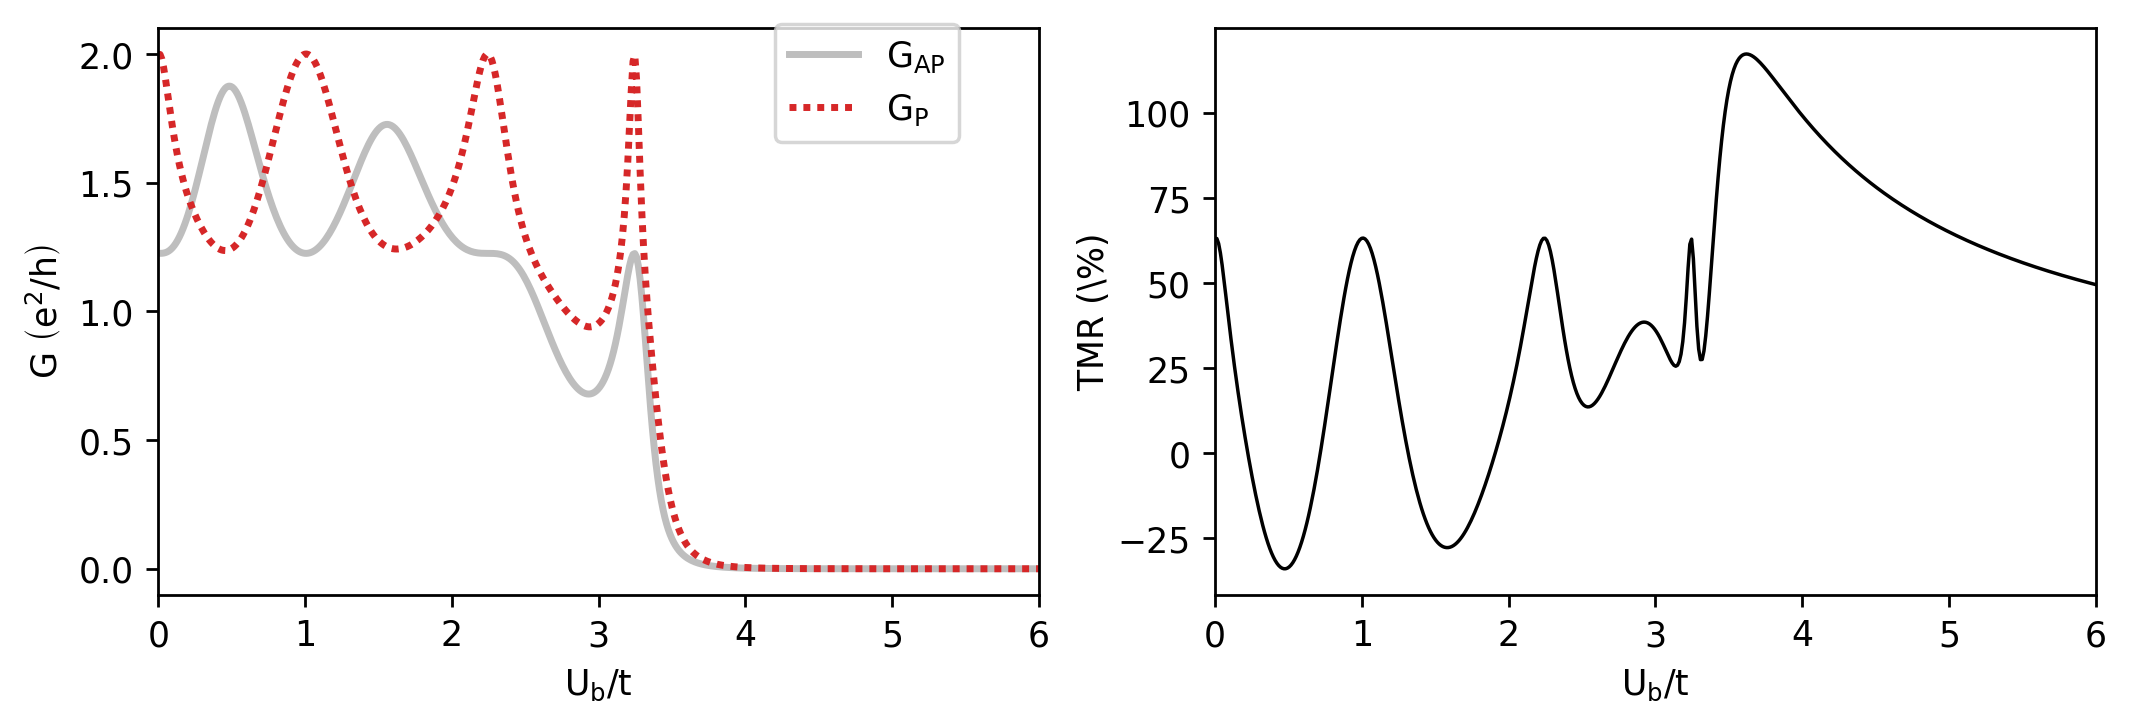

In [19]:
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['figure.figsize'] = (3, 2)


t_p = []
t_ap = []
tmr = []

potentials = np.linspace(0, 6, 500)
for pot in potentials:
    t_p.append(mtj_trans(n=5, ub=pot,  fermi_energy=0.5, jexc=0.9, parallel=True))
    t_ap.append(mtj_trans(n=5, ub=pot,  fermi_energy=0.5, jexc=0.9, parallel=False))
    tmr.append((t_p[-1] - t_ap[-1])*100/t_ap[-1])

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(potentials, t_ap, lw=2, c='#BEBEBE',
            label=r'${\rm G}_{\rm AP}$');

axs[0].plot(potentials, t_p, lw=2, ls=(0, (1, 1)), c='C3',
            label=r'${\rm G}_{\rm P}$');

axs[0].set_ylabel(r'G $\left(\rm e^2/\rm h\right)$')
axs[0].set_xlabel(r'${\rm U}_{\rm b}/{\rm t}$')

plt.sca(axs[0])  # Set the current axis to the first axis (axs[0])
plt.legend(loc=(0.7, 0.8));

axs[1].plot(potentials, tmr, lw=1, c='black', label='TMR');
axs[1].set_xlim(0, 6)
axs[0].set_xlim(0, 6)
axs[1].set_ylabel(r'${\rm TMR}$ (\%)', labelpad=2)
axs[1].set_xlabel(r'${\rm U}_{\rm b}/{\rm t}$');

## 3.2 3D tight-binding mixed real-space and k-space model of MTJ                                   
                                                            
For 3D MTJs with large cross section, we can avoid finite size effects of modelling it on 3D real-space tight-binding lattice by assuming that the junction is periodicically repeated in the transverse $xy$-plane for current flowing along the $z$-axis. The the transmission function (per unit cell) has to be "k-point sampled":                              
                                                            
$$ T(E) = \left(\frac{a}{2\pi}\right)^2 \int dk_x dk_y T(E,k_x,k_y) =
   \int dE_{xy} {\rm DOS}_\mathrm{2D}(E_{xy})T(E,E_{xy})$$ 
   
We speed up this by using the fact that $T$ depends on $k_x$,$k_y$ through the in-plane kinetic energy only 

$$ E_{xy}=-2t[\cos(k_xa)+\cos(k_ya)]$$

so we integrate once over energy using the 2D tight-binding density of states ${\rm DOS_{2D}}(E_{xy})$, rather than (computationally much more demanding) doing double integral over $k_x$,$k_y$.    

In [20]:
def transmission(sigma_left, sigma_right, gr):
    """Computes transmission function for 1D tight-binding
    chain attached to ferromagnetic electrodes
    """
    n = gr.shape[0]
    
    # Level broadening matrix from left FM electrode
    gamma_left = 1j*(sigma_left - np.conj(sigma_left.T))
    
    # Level broadening matrix from right FM electrode
    gamma_right = 1j*(sigma_right - np.conj(sigma_right.T)) 
    
    ga = np.conj(gr.T) # Advanced green function
    
    # Caroli et al. formula
    out = np.trace(gamma_right @ gr[n-2:,0:2] @ gamma_left @ ga[0:2, n-2:])
    
    return out.real

In [21]:
from scipy.special import ellipk


def mtj_3d(nx=40, t=1.0, t_lead=1.0, t_couple=1.0,
           fermi_energy=0.5, delta=0.9, de=0.015):
    
    """Computes transmission in 3D MTJ
    
    Parameters
    ----------
    nx : integer
        Number of sites in the barrier.
    t : float
        Nearest neighbor hopping in the tunnel barrier region.
    t_lead : float
        Hopping in the leads.
    t_couple : float
        Coupling between the FM leads and the tunnel
        barrier region.
    fermi_energy : float
        Fermi energy in the units of hopping measured from the bottom of the
        band.
    delta : float
        Exchange splitting as a fraction of E_F in the FM electrodes
    de : float
        Energy grid spacing.
    """
    
    e_bottom = -2*t     # Bottom of the band for 1D chain
    ef = fermi_energy*t - e_bottom
    delta = delta * ef
    
    n = 2*nx    # Define size of the Hamiltonian
    ham = np.zeros((nx, nx), dtype=complex)
    
    T_parallel = []       # A list to hold transmission for parallel (P)
    T_antiparallel = []   # A list to hold transmission for anti-parallel (AP)
    T_P = []              # A list to hold integral of transmission for P config.
    T_AP = []             # A list to hold integral of transmission for AP config.
    
    potentials = np.arange(0, 3, 0.1)
    for U_b in potentials:
        print('%.2f \r' % U_b, end='')
        # Loop over in-plane kinetic energy Eyz defined
        # on a grid of spacing de (that should avoid singularity at Eyz = 0)
        energies = np.arange(2*e_bottom, -2*e_bottom, de)
        
        t_p_sum = 0
        t_ap_sum = 0
    
        for energy_grid in energies:
            e_rel = (energy_grid / (4*t))**2
            dos_2d = 1./(4*t*np.pi**2) * ellipk(np.sqrt(1 - e_rel)) 
        
            # Exchange splitting for spin-up electrons is -delta/2 
            energy = fermi_energy - (-delta/2) - (-energy_grid)
            rad = 4*t_lead**2 - energy**2
            if (rad > 0):
                sigma_up = energy - 1j*np.sqrt(rad) 
            else: 
                sigma_up = energy - np.sign(energy)*np.sqrt(-rad) 
            const = t_couple**2 / (2*t_lead**2)
            sigma_up *= const
        
            # Exchange splitting for spin-down electrons is delta/2 
            energy = fermi_energy - (delta/2) - (-energy_grid)
            rad = 4*t_lead**2 - energy**2
            if (rad > 0):
                sigma_down = energy - 1j*np.sqrt(rad) 
            else: 
                sigma_down = energy - np.sign(energy)*np.sqrt(-rad) 
            const = t_couple**2 / (2*t_lead**2)
            sigma_down *= const
       
            # Set up Hamiltonian matrix
            
            hamil = np.zeros((nx, nx), dtype=complex)
            onsite_potential = U_b - delta/2 - energy_grid
            hamil += np.diag(onsite_potential * np.ones(nx))
            hamil += np.diag(-t*np.ones(nx-1), -1)
            hamil += np.diag(-t*np.ones(nx-1), 1)
            
            hamil = np.kron(hamil, np.eye(2))
            
            sigma_left = np.array([[sigma_up, 0], [0, sigma_down]])
            sigma_right = np.array([[sigma_up, 0], [0, sigma_down]])
            
            # Pay attention! Wrapping hamiltonian slice 
            # into a numpy array will create a copy, otherwise it will be an alias 
            left_potential = np.array(hamil[0:2, 0:2])  
            right_potential = np.array(hamil[-2:, -2:]) 
            
            hamil[0:2, 0:2] = left_potential + sigma_left
            hamil[-2:, -2:] = right_potential + sigma_right
            
            gr = np.linalg.inv(fermi_energy*np.eye(n) - hamil)
            
            T_parallel.append(transmission(sigma_left, sigma_right, gr))
            t_p_sum += (T_parallel[-1]*de*dos_2d)
            
            sigma_left = np.array([[sigma_up, 0], [0, sigma_down]])
            sigma_right = np.array([[sigma_down, 0], [0, sigma_up]])
            
            hamil[0:2, 0:2] = left_potential + sigma_left
            hamil[-2:, -2:] = right_potential + sigma_right
            
            gr = np.linalg.inv(fermi_energy*np.eye(n) - hamil)
            
            T_antiparallel.append(transmission(sigma_left, sigma_right, gr))
            t_ap_sum += (T_antiparallel[-1]*de*dos_2d)

        T_P.append(t_p_sum)
        T_AP.append(t_ap_sum)
    T_P = np.array(T_P)
    T_AP = np.array(T_AP)
    
    TMR = (T_P - T_AP) / T_AP * 100
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(potentials, TMR)
    ax.set_title('TMR vs barrier height')
    ax.set_xlabel(r'${\rm U}_{\rm b}/{\rm t}$')
    ax.set_ylabel('TMR (\%)')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs[0].plot(potentials, T_P)
    axs[1].plot(potentials, T_AP)
    axs[0].set_title('Conductance in P configuration')
    axs[1].set_title('Conductance in AP configuration')
    axs[0].set_ylabel(r'$G_\mathrm{P}$ $\left(\frac{\rm e^2}{\rm h}\right)$')
    axs[1].set_ylabel(r'$G_\mathrm{AP}$ $\left(\frac{\rm e^2}{\rm h}\right)$')
    axs[0].set_xlabel(r'${\rm U}_{\rm b}/{\rm t}$')
    axs[1].set_xlabel(r'${\rm U}_{\rm b}/{\rm t}$')
    
    fig.tight_layout(h_pad=1.0, w_pad=2.0)
    fig.set_dpi(300)

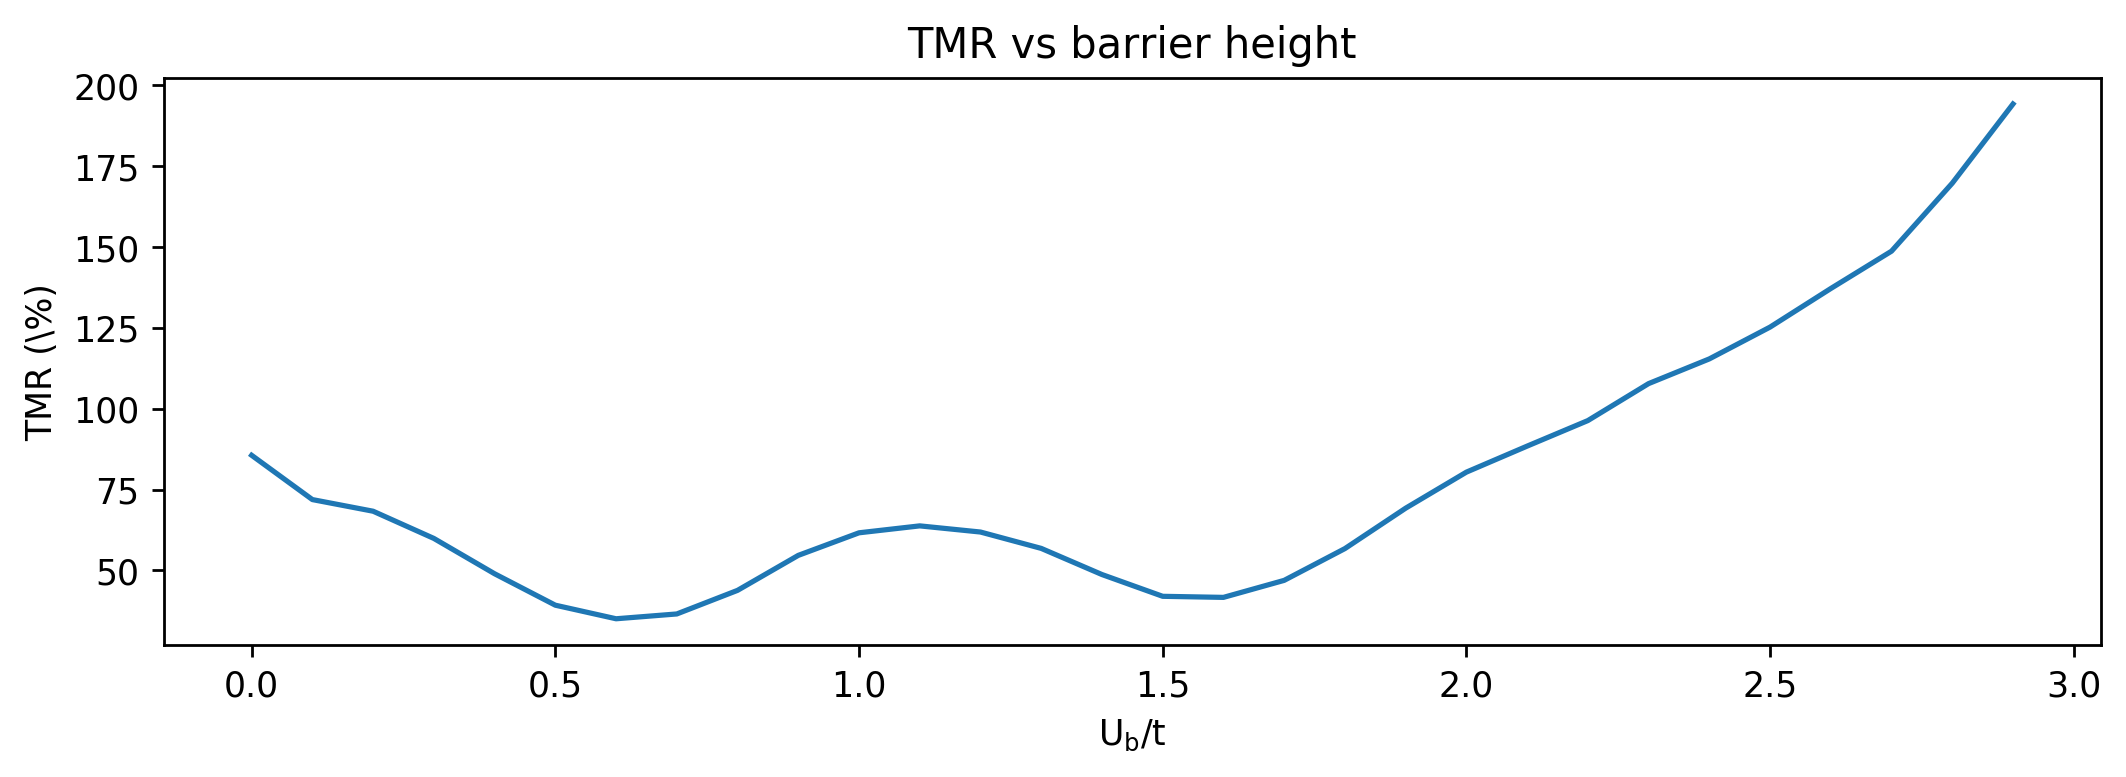

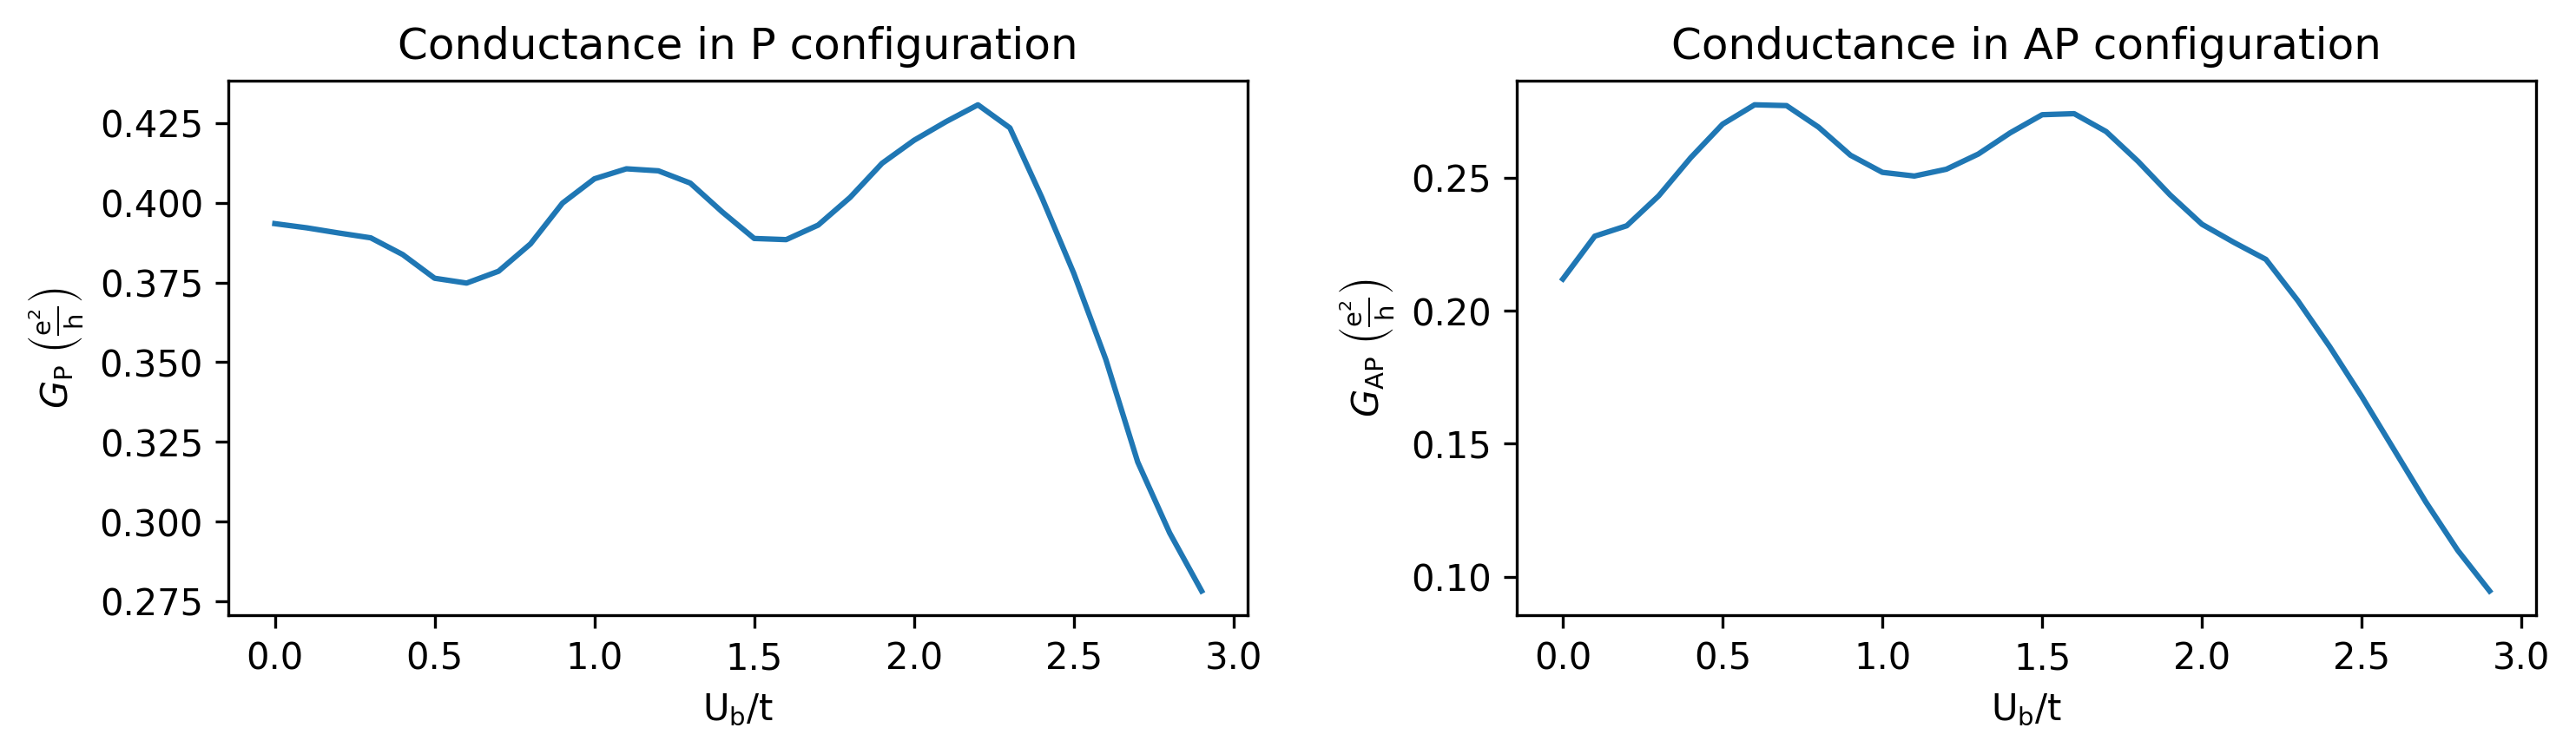

In [22]:
mtj_3d(nx=5, t=1.0, t_lead=1.0, t_couple=1.0, fermi_energy=0.5, delta=0.9, de=0.015)

## 3.3 Spectral function on atomic monolayers of 3D MTJ

This quantity, which is probed experimentally on exposed surfaces by [angle-resolved photoemission spectroscopy (ARPES)](https://www.annualreviews.org/doi/abs/10.1146/annurev-conmatphys-020911-125027), is computed from the retarded Green function 
in mixed real-space and k-space representation:

$$ A(E,z;k_x,k_y) = -\frac{1}{\pi} \mathrm{Im}\, G^r(E,z,z;k_x,k_y)$$

First, we want to define a function to compute $A(E, z; k_x, k_y)$ for a specific
value of $k_x$ and $k_y$ parameters.

In [23]:
def mtj_spectral(n=40, t=1.0, t_lead=1.0, t_couple=1.0, ub=0,
                 kx=0, ky=0, fermi_energy=0.5, delta=0.9, site_index=0):
    
    e_bottom = -2*t     # Bottom of the band for 1D chain
    ef = fermi_energy*t - e_bottom
    delta = delta * ef
    
    ham = np.zeros((n, n), dtype=complex)
    
    onsite_kx_ky = -2*t*(np.cos(kx) + np.cos(ky))
    
    # Exchange splitting for spin-up electrons is -delta/2 
    energy = fermi_energy - (-delta/2) + onsite_kx_ky
    rad = 4*t_lead**2 - energy**2
    if (rad > 0):
        sigma_up = energy - 1j*np.sqrt(rad) 
    else: 
        sigma_up = energy - np.sign(energy)*np.sqrt(-rad) 
    const = t_couple**2 / (2*t_lead**2)
    sigma_up *= const
        
    # Exchange splitting for spin-down electrons is delta/2 
    energy = fermi_energy - (delta/2) + onsite_kx_ky
    rad = 4*t_lead**2 - energy**2
    if (rad > 0):
        sigma_down = energy - 1j*np.sqrt(rad) 
    else: 
        sigma_down = energy - np.sign(energy)*np.sqrt(-rad) 
    const = t_couple**2 / (2*t_lead**2)
    sigma_down *= const
       
    # Set up Hamiltonian matrix
    hamil = np.zeros((n, n), dtype=complex)
    onsite_potential = ub - delta/2
    onsite_potential += onsite_kx_ky
    hamil += np.diag(onsite_potential * np.ones(n))
    hamil += np.diag(-t*np.ones(n-1), -1)
    hamil += np.diag(-t*np.ones(n-1), 1)
    hamil = np.kron(hamil, np.eye(2))
            
    sigma_left = np.array([[sigma_up, 0], [0, sigma_down]])
    sigma_right = np.array([[sigma_up, 0], [0, sigma_down]])
            
    left_potential = np.array(hamil[0:2, 0:2])
    right_potential = np.array(hamil[-2:, -2:])
            
    hamil[0:2, 0:2] = left_potential + sigma_left
    hamil[-2:, -2:] = right_potential + sigma_right
            
    gr = np.linalg.inv(fermi_energy*np.eye(2*n) - hamil)
    ga = np.conj(gr.T)
    im_g = (gr - ga)/2j
    a_up = -im_g[2*site_index, 2*site_index] / np.pi
    a_down = -im_g[2*site_index+1, 2*site_index+1] / np.pi
    
    return a_up, a_down

Next, we define a function which computes and plots the spin-resolved 
spectral function for two selected layers.

In [24]:
def plot_spectral(n=10, nkx=80, nky=80, ub=0, ef=0.5, jexc=0.5, layer1=0, layer2=5):
    """ 
    Parameters
    ----------
    n : int
        Number of sites in the main (barrier) region.
    nkx : integer
        Number of points to sample kx.
    nky : integer 
        Number of points to sample ky.
    ub : float
        Onsite potential in the main (barrier) region.
    ef : float
        Fermi energy
    jexc : float 
        Coupling between the magnetic moments and electron spins in the FM leads
    layer1 : int
        First layer to compute spectral function (any integer from 1 to n).
        Notice that contrary to Python conventions, the indexing here starts
        at 1.
    layer2 : int
        Second layer to compute spectral function (any integer from 1 to n).
    
    Returns
    -------
    Plots a 4-panel figure showning spectral function for two selected layers
    and for both spin components.
    """
    
    # First, we define kx and ky points
    kxs = np.linspace(-np.pi, np.pi, nkx)
    kys = np.linspace(-np.pi, np.pi, nky)
    
    # Spectral functions for spin up and down in the first selected layer
    a1_u = np.zeros((nkx, nky))  
    a1_d = np.zeros((nkx, nky))  
    
    # Spectral functions for spin up and down in the second selected layer
    a2_u = np.zeros((nkx, nky))  
    a2_d = np.zeros((nkx, nky))  
    
    # Check if the layers are inside of the main (barrier) region
    in1 = 0 < layer1 < n+1
    in2 = 0 < layer2 < n+1
    if not (in1 and in2):
        raise ValueError('Layer indices must go from 1 to n=%d' % n)

    print('Computing for the 1st layer (z = %d)' % layer1)
    for i, kx in enumerate(kxs):
        for j, ky in enumerate(kys):
            sp_u, sp_d = mtj_spectral(n=n, kx=kx, ky=ky, 
                                      fermi_energy=ef,
                                      ub=ub,
                                      site_index=layer1-1,
                                      delta=jexc)
            a1_u[i, j] = sp_u
            a1_d[i, j] = sp_d
            
    print('Computing for the 2nd layer (z = %d)' % layer2)
    for i, kx in enumerate(kxs):
        for j, ky in enumerate(kys):
            sp_u, sp_d = mtj_spectral(n=n, kx=kx, ky=ky, 
                                      fermi_energy=ef,
                                      ub=ub,
                                      site_index=layer2-1,
                                      delta=jexc)
            a2_u[i, j] = sp_u
            a2_d[i, j] = sp_d
        
    # Plot the results
    fig, ax = plt.subplots(2, 2, figsize=(4, 4))
    ax[0, 0].imshow(a1_u, extent=[-np.pi, np.pi, -np.pi, np.pi],
                    origin='lower', aspect='auto', interpolation='bicubic');
    ax[0, 1].imshow(a2_u, extent=[-np.pi, np.pi, -np.pi, np.pi],
                    origin='lower', aspect='auto', interpolation='bicubic');
    ax[1, 0].imshow(a1_d, extent=[-np.pi, np.pi, -np.pi, np.pi],
                    origin='lower', aspect='auto', interpolation='bicubic');
    ax[1, 1].imshow(a2_d, extent=[-np.pi, np.pi, -np.pi, np.pi],
                    origin='lower', aspect='auto', interpolation='bicubic');
    
    fig.tight_layout(h_pad=1.0, w_pad=2.0)
    fig.set_dpi(300)

    ax[1, 0].set_xlabel(r'${\rm k}_{\rm x}$')
    ax[1, 1].set_xlabel(r'${\rm k}_{\rm x}$')
    ax[0, 0].set_ylabel(r'${\rm k}_{\rm y}$')
    ax[1, 0].set_ylabel(r'${\rm k}_{\rm y}$')

    ax[0, 0].text(0.5, 1.01, 'Layer %d' % (layer1), 
                  va='bottom', ha='center', transform=ax[0, 0].transAxes);
    ax[0, 1].text(0.5, 1.01, 'Layer %d' % (layer2), 
                  va='bottom', ha='center', transform=ax[0, 1].transAxes);

    ax[0, 1].text(1.01, 0.5, r'spin-up',
                  va='center', ha='left',
                  transform=ax[0, 1].transAxes, rotation=-90);
    ax[1, 1].text(1.01, 0.5, r'spin-down',
                  va='center', ha='left',
                  transform=ax[1, 1].transAxes, rotation=-90);

Compute spectral function on the 1st and 5th atomic monolayer of the insulating barrier. The former is in direct contact with the left ferromagnetic lead, and it will be affected by evanescent wavefunctions injected by it, while the latter is in the middle of the barrier composed of 10 atomic monolayers. 

Computing for the 1st layer (z = 1)


/opt/anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part


Computing for the 2nd layer (z = 5)


/opt/anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:68: ComplexWarning: Casting complex values to real discards the imaginary part


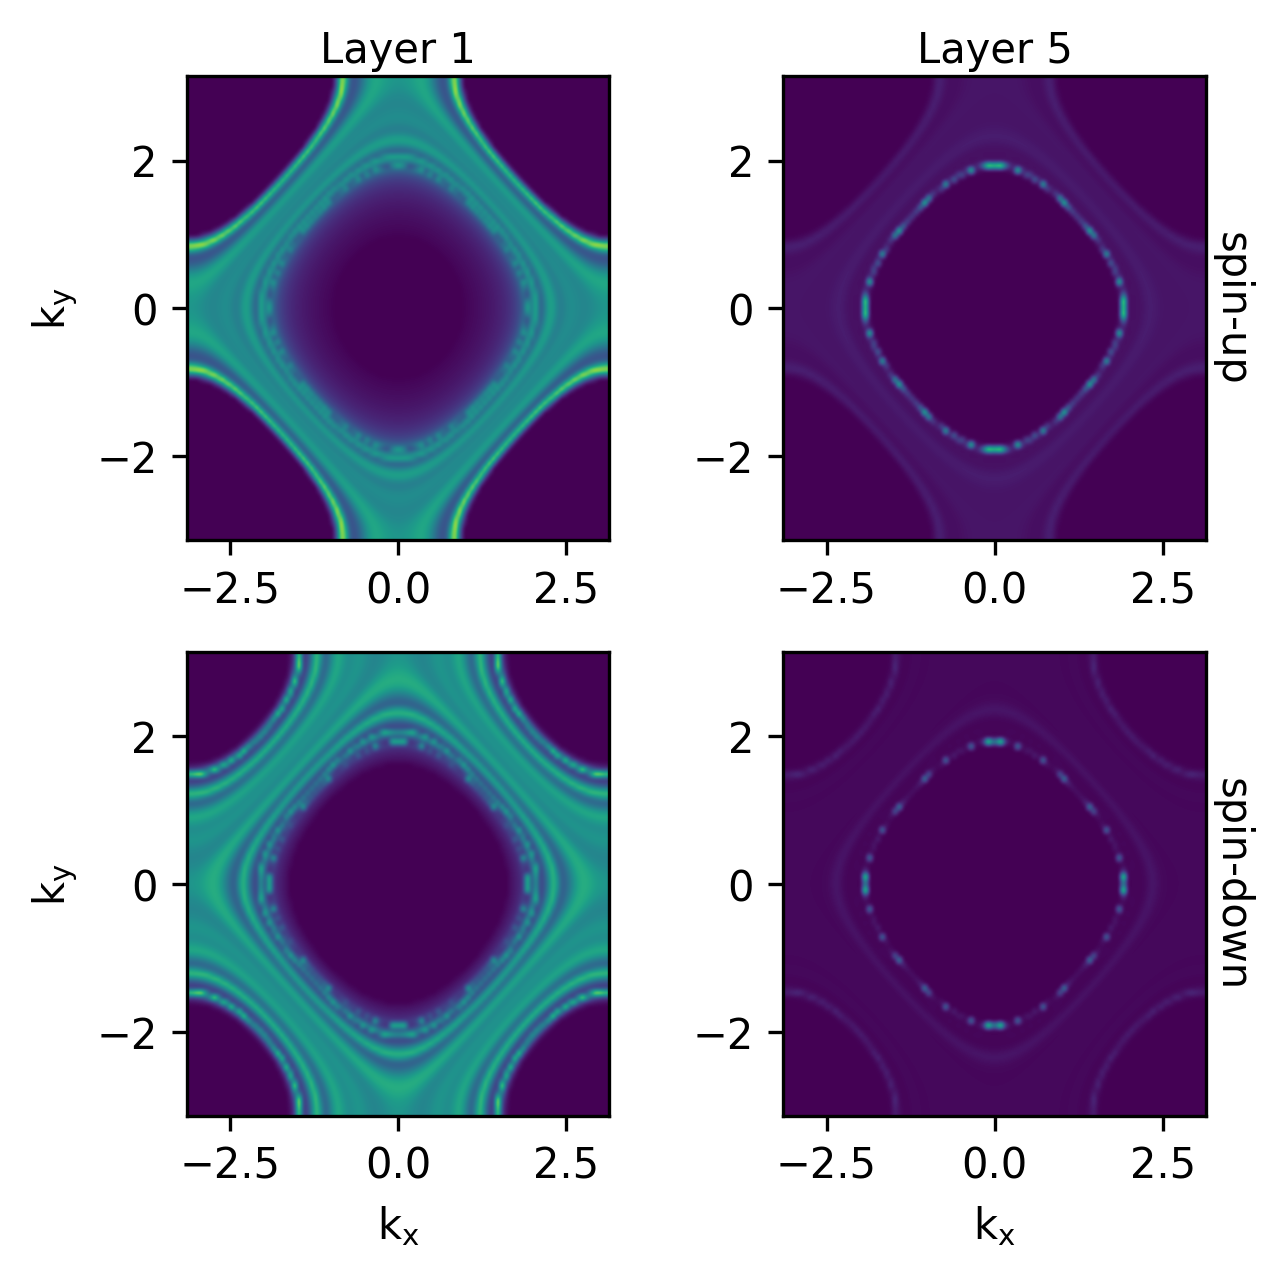

In [25]:
plot_spectral(n=10, nkx=100, nky=100, ub=0.5, ef=0.5, jexc=0.5, layer1=1, layer2=5)

Send corrections to <code>bnikolic@udel.edu</code>